# 8.3 Lab: Decision Trees

## 8.3.3b Bagging and Random Forest - Classifier

This is a repeat of the 8.3.3 lab but with a classifier instead of regressor. This will use the `Heart` data set available as a `csv` file. We will use `pandas` to read the data set in as a data frame.

We will use the `sklearn.ensemble` namespace and its associated classifers and regressors for [ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html). Emsemble methods combine the predictions of several other models to improve generalizability and robustness. 

Note that bagging is simply a special case of Random Forest where `m = p` so that the same model can be used for both. Both build on the bootstrap concept (see Chapter 5).

Decision trees suffer from *high variance*, in which the results from fitting different data sets from the same population can lead to quite different outcomes. While *low variance* will provide similar results against distinct data sets. 

In bagging, we will fit `B` number of trees and use a majority vote. A large `B` will not lead to overfitting as the changing in error will slow down. 

We can use out-of-bag (OOB) observations, observations not used in the training, to estimate the test error rate without cross-validation or the validation set approach.

Random forests help decorrelate the trees by randomly selecting predictors, `m`, for fitting at each split instead of allowing all the predictors, `p`, to be available. When `m=p`, we are simply using bagging. 

** It is important to note that the default for the parameter `max_features` is `auto` in which for the `RandomForestRegressor` it becomes `max_features = n_features` and for the `RandomForestClassifer` it becomes `max_features = sqrt (n_features)`. Other recommendations for the maximum features for a regressor have set the value to `p / 3`.

### Imports



In [1]:
from typing import List, Dict, Tuple, Sequence, Union
import sys

import statsmodels # root namespace for typing
import statsmodels.api as statsModels # alias to hide the extra api namespace

import numpy
import pandas 

import sklearn
import sklearn.inspection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as pyplot
import seaborn


### Data Acquisition

The heart data is available as an external `csv` file and contains a binary outcome `AHD` for heart disease for patients taht presented with chest pain. The first column in the file contains an index. 


In [2]:
heartDataFrameRaw: pandas.DataFrame = pandas.read_csv ("../islr-data/Heart.csv", index_col = 0)
heartDataFrameRaw.head ()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


We need to find any missing values on the rows that will need to be imputed or filled.

In [3]:
heartDataFrameRaw.loc [heartDataFrameRaw.isnull().any (axis = 1)]


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
88,53,0,nonanginal,128,216,0,2,115,0,0.0,1,0.0,NaN,No
167,52,1,nonanginal,138,223,0,0,169,0,0.0,1,NaN,normal,No
193,43,1,asymptomatic,132,247,1,2,143,1,0.1,2,NaN,reversable,Yes
267,52,1,asymptomatic,128,204,1,0,156,1,1.0,2,0.0,NaN,Yes
288,58,1,nontypical,125,220,0,0,144,0,0.4,2,NaN,reversable,No
303,38,1,nonanginal,138,175,0,0,173,0,0.0,1,NaN,normal,No


mean: 0.6722  median: 0.0000


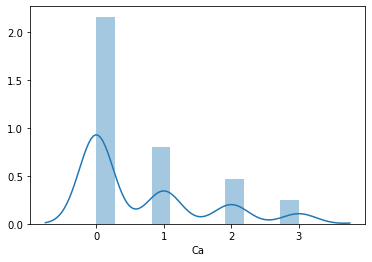

In [4]:
seaborn.distplot (heartDataFrameRaw ["Ca"])
print ("mean: {:.4f}  median: {:.4f}". format (heartDataFrameRaw ["Ca"].mean (), heartDataFrameRaw ["Ca"].median ()))

In [5]:
heartDataFrameRaw.corr ()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
Age,1.000000,-0.097542,0.284946,0.208950,0.118530,0.148868,-0.393806,0.091661,0.203805,0.161770,0.362605
Sex,-0.097542,1.000000,-0.064456,-0.199915,0.047862,0.021647,-0.048663,0.146201,0.102173,0.037533,0.093185
RestBP,0.284946,-0.064456,1.000000,0.130120,0.175340,0.146560,-0.045351,0.064762,0.189171,0.117382,0.098773
Chol,0.208950,-0.199915,0.130120,1.000000,0.009841,0.171043,-0.003432,0.061310,0.046564,-0.004062,0.119000
Fbs,0.118530,0.047862,0.175340,0.009841,1.000000,0.069564,-0.007854,0.025665,0.005747,0.059894,0.145478
RestECG,0.148868,0.021647,0.146560,0.171043,0.069564,1.000000,-0.083389,0.084867,0.114133,0.133946,0.128343
MaxHR,-0.393806,-0.048663,-0.045351,-0.003432,-0.007854,-0.083389,1.000000,-0.378103,-0.343085,-0.385601,-0.264246
ExAng,0.091661,0.146201,0.064762,0.061310,0.025665,0.084867,-0.378103,1.000000,0.288223,0.257748,0.145570
Oldpeak,0.203805,0.102173,0.189171,0.046564,0.005747,0.114133,-0.343085,0.288223,1.000000,0.577537,0.295832
Slope,0.161770,0.037533,0.117382,-0.004062,0.059894,0.133946,-0.385601,0.257748,0.577537,1.000000,0.110119


### Data Adjustments

The original data set has categorical variables `Sex` (which is already encoded as numeric), `ChestPain`, and `Thal` (Thallium Stress Test) and the response variable `AHD` with values `Yes` and `No`. 

`ChestPain` values are `asymptomatic` (asymptomatic), `nonanginal` (non-anginal pain), `nontypical` (atypical angina), and `typical` (typical angina). The categorization is assigned by the number of criteria meet and can be seen as an ordered factor. We will use a label encoder that will change the text to discrete values for each level of the factor.

`Thal` (Thallium Stress Test) values are `normal`, `reversable`, and `fixed` (non-reversable defect). The categorization is assigned by evaluation of imaging and can be seen as an ordered factor. We will use a label encoder that will change the text to discrete values for each level of the factor. 


`Thal` has missing values for 2 rows. We will use a new value `unknown` as the replacement. 

`Ca` has missing values for 4 rows. We have a couple of options to fill in the rows. We can impute the data from other data, we can use the mean, or we can use the median. As the values are discrete and are heavy right tailed, using the mean would not be appropriate here. There is an experimental [`IterativeImputer`](https://scikit-learn.org/stable/modules/impute.html) that will impute missing values across a data frame. Since we only want to impute the single `Ca` column and we want to impute it as a discrete value, we will simply use a decision tree for a non-parameteric imputation.


In [6]:
heartDataFrame = heartDataFrameRaw.copy ()

# [ChestPain] use a label encoder to map the category variable to discrete ordered integers
chestPainEncoder = sklearn.preprocessing.LabelEncoder ().fit (["asymptomatic", "nonanginal", "nontypical", "typical"])
heartDataFrame ["ChestPain"] = chestPainEncoder.transform (heartDataFrame ["ChestPain"])

# [Thai] use a label encoder to map the category variable to discrete ordered integers
heartDataFrame ["Thal"].fillna ("unknown", inplace = True)
thalEncoder = sklearn.preprocessing.LabelEncoder ().fit (["unknown", "normal", "reversable", "fixed"])
heartDataFrame ["Thal"] = thalEncoder.transform (heartDataFrame ["Thal"])

# [AHD] use a label encoder to map the category variable to discrete ordered integers
ahdEncoder = sklearn.preprocessing.LabelEncoder ().fit (["No", "Yes"])
heartDataFrame ["AHD"] = ahdEncoder.transform (heartDataFrame ["AHD"])

In [7]:
 # allow the decision tree to overfit on all the data with no hold out
caImputer = sklearn.tree.DecisionTreeClassifier ().fit (
        X = heartDataFrame.loc [heartDataFrame ["Ca"].isna () == False].iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]],
        y = heartDataFrame.loc [heartDataFrame ["Ca"].isna () == False].iloc[:,11])

# predict missing values    
imputedValues = caImputer.predict (heartDataFrame.loc [heartDataFrame ["Ca"].isna () == True].iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]])

imputedValues



array([0., 0., 0., 0.])

In [8]:
# since the decision tree returned all predicted values as 0, we'll just fill in the na with 0
heartDataFrame ["Ca"].fillna (0, inplace = True)

In [9]:
# print sample of final data set
heartDataFrame.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0,0
2,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1,1
3,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1
4,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1,0


### Modeling
Fit a random forest model with `mtry = 13` which indicates that all 13 variables should be considered for each split, so that `m = p = 13` and we are bagging.

In R, the default values for `mtry` is `p/3` for regression trees and `sqrt(p)` for classification trees.

In Python, the parameter that controls the number of predictors available at a split is `max_features`. The default is `auto` so that `m = p` and you get bagging. 
```

In [10]:
# slice the data frame into the X matrix and the y response vector 
X = heartDataFrame.iloc [:, 0:-1]  # skip response variable in the last position
y = heartDataFrame.loc [:, ["AHD"]].to_numpy().ravel () # as vector

# set the seed for repeatable results
numpy.random.seed (5) 

# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# instatiate an instance of the sklearn.ensemble.RandomForestClassifier
randomForestModel = RandomForestClassifier (n_estimators = 500, max_features = len (X.columns), oob_score = True) # fit all features
randomForestModel = randomForestModel.fit (X = trainX, y = trainy)


In [11]:
# create summary 
print (randomForestModel)
print ("               Type of random forest: " + ("regression" if isinstance (randomForestModel, RandomForestRegressor) else "classification"))
print ("                     Number of trees: {:0d}".format (randomForestModel.n_estimators))
print ("No. of variables tried at each split: {:0d}".format (randomForestModel.max_features))
print ("Out-of-bag (OOB) Score: {:.4f}".format (randomForestModel.oob_score_))


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=13,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 13
Out-of-bag (OOB) Score: 0.7417


In [12]:
print ("Test Set Confusion Matrix and Classification Report")

# print the confusion matrix and classification report 
yhat = randomForestModel.predict (testX)
print (confusion_matrix (y_true = testy, y_pred = yhat))
print (sklearn.metrics.classification_report (testy, randomForestModel.predict (testX)))


Test Set Confusion Matrix and Classification Report
[[76  8]
 [13 55]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        84
           1       0.87      0.81      0.84        68

    accuracy                           0.86       152
   macro avg       0.86      0.86      0.86       152
weighted avg       0.86      0.86      0.86       152



Refitting with smaller set of trees (original was set to 500 to mirror the default in R). In R, we use the `ntree` parameter, and in Python, we use the `n_estimators` parameter.

Both examples above are examples of bagging since `m = p = 13`. In the following example, we will limit the number of predictors available to the algorithm to choose from at each split. For classification, the recommendation is sqrt (p), and for regression, the recommendation is p/3.  


### Figure 8.8

The below code will replicate Figure 8.8 on page 318 which shows the bagging and random forest results fo the Heart data for trees `B` between 1 and 300 and `m = sqrt (p)` for the random forests.


In [13]:
# reuse the same training/test split, set the maximum features to sqrt (p)
forestFeatures: int = int (numpy.sqrt (len (trainX.columns)))
baggingFeatures: int = len (trainX.columns)

errorResults = []
for currentMaximumTrees in range (1, 301, 5):
    baggingModel = RandomForestClassifier (n_estimators = currentMaximumTrees, max_features = baggingFeatures, oob_score = True).fit (trainX, trainy)
    forestModel = RandomForestClassifier (n_estimators = currentMaximumTrees, max_features = forestFeatures, oob_score = True).fit (trainX, trainy)

    errorResults.append ({
        "Trees": currentMaximumTrees,
        "Test: Bagging": 1 - baggingModel.score (testX, testy),
        "Test: RandomForest": 1 - forestModel.score (testX, testy),
        "OOB: Bagging": 1 - baggingModel.oob_score_,
        "OOB: RandomForest": 1 - forestModel.oob_score_
    })



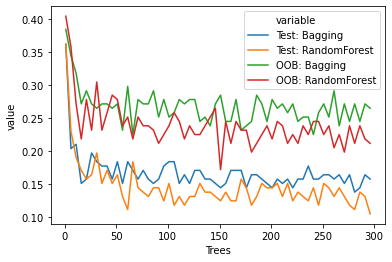

In [14]:
errorResultsDataFrame = pandas.DataFrame  (errorResults)
axes = seaborn.lineplot (x = "Trees", y = "value", hue = "variable", data = pandas.melt (errorResultsDataFrame, ["Trees"]))


The random forest models outperform the bagging models almost consistently in both the OOB and the test set. 

** I will note that the test scores are lower than the OOB scores, which should not be true (generally). At some point, I will need to make sure that the OOB and the score calculations are calculating the same metric (accuracy).

### Feature Importance

In [15]:

# instatiate an instance of the sklearn.ensemble.RandomForestClassifier
randomForestModel = RandomForestClassifier (n_estimators = 500, max_features = int (numpy.sqrt (len (X.columns))), oob_score = True)
randomForestModel = randomForestModel.fit (X = trainX, y = trainy)

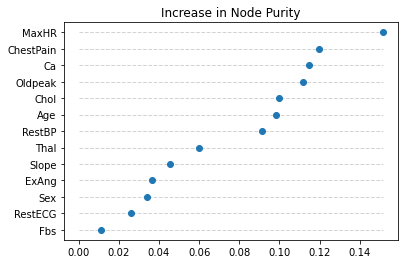

In [16]:
# combine the 2 arrays into a set of tuples of (importance, column-name) and sort
featureImportance = zip (list (randomForestModel.feature_importances_), list (testX.columns))
featureImportance = sorted (featureImportance, reverse=False)
maxImportance = max (randomForestModel.feature_importances_)

for currentImportance in list (map (lambda current: current[1], featureImportance)):
    pyplot.plot ([0, maxImportance], [currentImportance, currentImportance], linestyle = "--", linewidth = 1, color = "lightgray")

pyplot.scatter (x = list (map (lambda current: current[0], featureImportance)), 
                y = list (map (lambda current: current[1], featureImportance)), zorder=10)

ignore = pyplot.title ("Increase in Node Purity")           

### Permutation Importance 

We will look at permutation importance to compare the impurity-based feature importance with the permutation importance with the test set. The impurity-based feature importance is based solely on the training data set which can cause features to overfit and show a higher predictive importance than is true. The permutation method below can be used both with the training and test set. 

Please see [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

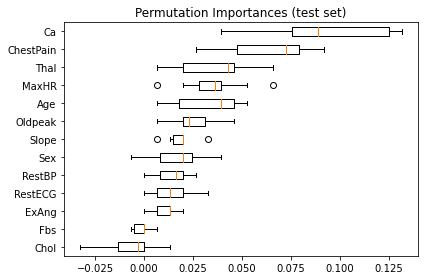

In [17]:
# sklearn.inspection.permutation_importance
permutationImportance = sklearn.inspection.permutation_importance (randomForestModel, testX, testy, n_repeats = 10, n_jobs = 2)

importanceSortedIndex = permutationImportance.importances_mean.argsort ()

figure, axes = pyplot.subplots ()
axes.boxplot (permutationImportance.importances [importanceSortedIndex].T, vert = False, 
            labels = testX.columns [importanceSortedIndex])
axes.set_title ("Permutation Importances (test set)")        
figure.tight_layout()
pyplot.show ()